## 1. Pre-procesamiento de los datos antes del entrenamiento
Se realizan las conversiones a sus correspondientes valores numéricos o categóricos, se eliminan las columnas que no se utilizarán y se separan los datos de entrenamiento y prueba.

In [49]:
import pandas as pd
from datetime import datetime

# Carga los datos
data = pd.read_csv('../1_precios_canasta/canasta_basica.csv')
df = pd.DataFrame(data)

# Calcula el promedio de las columnas "Precio Mínimo" y "Precio Máximo"
df['Precio'] = df[['Precio Mínimo', 'Precio Máximo']].mean(axis=1)

# Elimina las columnas "Precio Mínimo" y "Precio Máximo"
df.drop(['Precio Mínimo', 'Precio Máximo', 'Unidad de Medida'], axis=1, inplace=True)

df

,Fecha,Producto,Precio
0,2022-01-01,Aceite Mixto,0.0
1,2022-01-01,Arroz largo,0.0
2,2022-01-01,Azúcar Estándar,0.0
3,2022-01-01,Harina de Trigo,0.0
4,2022-01-01,Frijol Flor de Mayo,0.0
...,...,...,...
8283,2023-04-16,Lechuga romana,12.5
8284,2023-04-16,Papa alpha,23.0
8285,2023-04-16,Pepino,13.0
8286,2023-04-16,Tomate verde,15.5


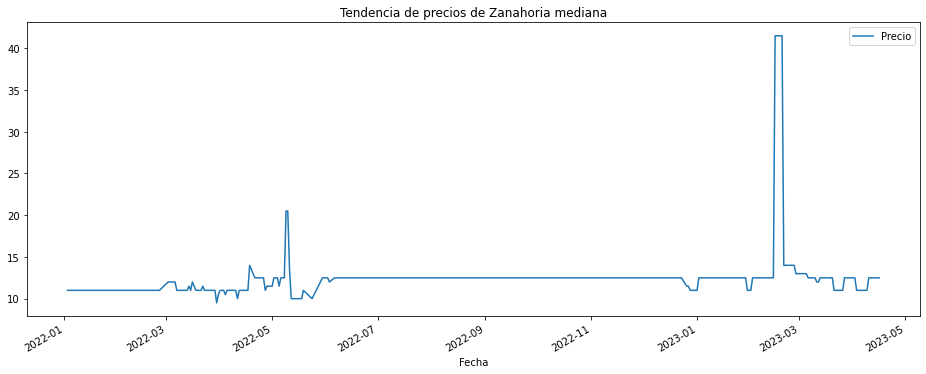

In [45]:
import matplotlib.pyplot as plt
# Filtrar los datos para obtener los precios de Zanahoria mediana
df_insumo = df[(df["Producto"] == "Zanahoria mediana") & (df["Precio"] != 0)][["Fecha", "Precio"]]
# Convertir la columna "Fecha" a formato de fecha
df_insumo["Fecha"] = pd.to_datetime(df_insumo["Fecha"])

# Establecer la columna "Fecha" como el índice del DataFrame
df_insumo = df_insumo.set_index("Fecha")

# Graficar la tendencia de precios
fig, ax = plt.subplots(figsize=(16,6))
df_insumo.plot(ax=ax)
ax.set(title="Tendencia de precios de Zanahoria mediana")
plt.show()

# 2. Modelo de series de tiempo
### Entrenamiento del modelo
Debido a que se necesitan predecir precios futuros a través del tiempo, se utilizará un modelo de series de tiempo. Este modelo se basa en la predicción de un valor futuro a partir de un valor pasado. 

En este caso, es necesario evaluar las tendencias de los precios a través del tiempo para poder predecir los precios de periodos siguientes por día, semana, mes o año. Para este caso, se manejará el precio de cierre de cada día.

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# La función arima_predictor es una herramienta personalizada que recibe como entrada:
# - Un DataFrame df
# - El nombre del insumo a predecir
# - Tres parámetros de ARIMA p, d y q.
# La función realiza los siguientes pasos:

# Devuelve dos elementos:
# 1. El DataFrame filtrado y procesado df_insumo.
# 2. Los valores predichos para los próximos 7 días.
def arima_predictor(df, insumo, p, d, q):
    # Filtra el dataframe para obtener los datos del producto "Producto1"
    df_insumo = df[(df["Producto"] == insumo) & (df["Precio"] != 0)][["Fecha", "Precio"]]
    # Convierte la columna "Fecha" a formato de fecha
    df_insumo["Fecha"] = pd.to_datetime(df_insumo["Fecha"])
    # Elimina las fechas duplicadas
    df_insumo = df_insumo.drop_duplicates(subset=['Fecha'])
    # Establece la columna "Fecha" como el índice del DataFrame
    df_insumo = df_insumo.set_index("Fecha")
    # Especifica la frecuencia de las fechas en el índice
    df_insumo = df_insumo.asfreq(freq='D')
    # Crea modelo ARIMA
    model = ARIMA(df_insumo, order=(p, d, q))
    # Ajusta el modelo a los datos
    model_fit = model.fit()
    # Predice precios para los próximos 7 días
    predicciones = model_fit.forecast(steps=7)
    # Imprime las predicciones de los 7 días próximos
    return df_insumo, predicciones

### Graficación de los datos
Se grafican los datos de entrenamiento y prueba para poder visualizar la tendencia de los precios a través del tiempo.

In [58]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5)

def plot_predictions(df_insumo, predicciones, insumo):
    # Graficar los datos históricos
    plt.plot(df_insumo, label='Datos históricos')
    # Graficar las predicciones
    plt.plot(predicciones, label='Predicciones')
    # Agregar título y etiquetas a los ejes
    plt.title('Predicciones de precios para ' + insumo)
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    # Mostrar leyenda y graficar
    plt.legend()
    plt.show()

#### Ejemplos de algunos insumos para visualizar la tendencia de los precios a través del tiempo.
##### 1. Zanahoria mediana

In [57]:
zan_df, zan_pred = arima_predictor(df, "Zanahoria mediana", 1, 1, 1)
zan_pred

2023-04-17    12.574562
2023-04-18    12.633212
2023-04-19    12.679346
2023-04-20    12.715635
2023-04-21    12.744180
2023-04-22    12.766634
2023-04-23    12.784296
Freq: D, Name: predicted_mean, dtype: float64

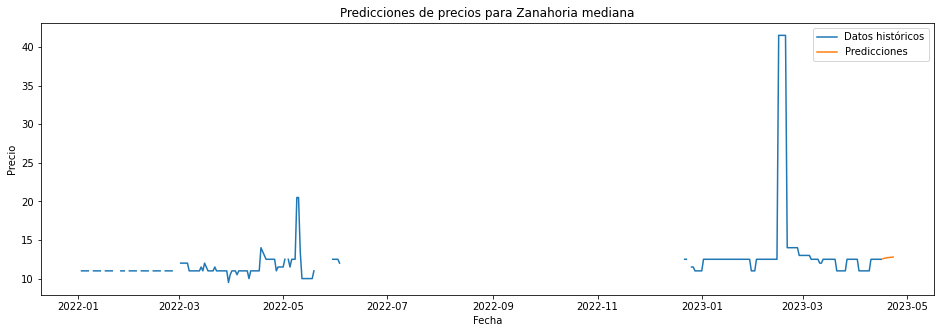

In [59]:
plot_predictions(zan_df, zan_pred, "Zanahoria mediana")

##### 2. Huevo Blanco

In [61]:
huevo_df, huevo_pred = arima_predictor(df, "Huevo Blanco", 1, 1, 1)
huevo_pred

2023-04-17    34.397416
2023-04-18    35.194049
2023-04-19    35.901218
2023-04-20    36.528969
2023-04-21    37.086221
2023-04-22    37.580893
2023-04-23    38.020011
Freq: D, Name: predicted_mean, dtype: float64

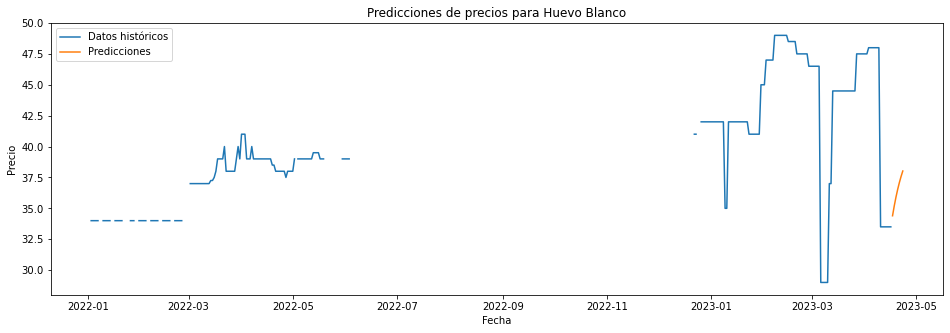

In [62]:
plot_predictions(huevo_df, huevo_pred, "Huevo Blanco")

#### 3. Manzana Golden

In [63]:
manzana_df, manzana_pred = arima_predictor(df, "Manzana Golden", 1, 1, 1)
manzana_pred

2023-04-17    44.723546
2023-04-18    44.656922
2023-04-19    44.640866
2023-04-20    44.636996
2023-04-21    44.636064
2023-04-22    44.635839
2023-04-23    44.635785
Freq: D, Name: predicted_mean, dtype: float64

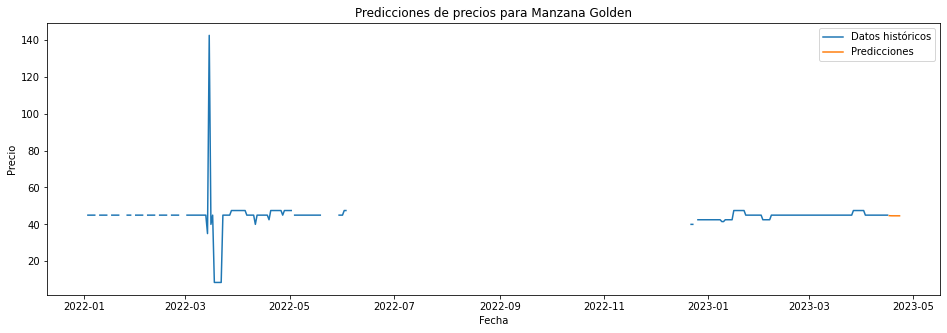

In [64]:
plot_predictions(manzana_df, manzana_pred, "Manzana Golden")